In [1]:
import cv2
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt

In [2]:
gt_yaml = r"/home/chris/Data/Projects/Pose Estimation/EfficientPose/data/xray/cube/data/00/gt.yml"
images_dir = r"/home/chris/Data/Projects/Pose Estimation/EfficientPose/data/xray/cube/data/00/rgb"
mesh_path = r"/home/chris/Data/Projects/Pose Estimation/EfficientPose/data/xray/cube/models/obj_00.ply"


In [3]:
def get_3D_corners(vertices):
    
    min_x = np.min(vertices[0,:])
    max_x = np.max(vertices[0,:])
    min_y = np.min(vertices[1,:])
    max_y = np.max(vertices[1,:])
    min_z = np.min(vertices[2,:])
    max_z = np.max(vertices[2,:])
    corners = np.array([[min_x, min_y, min_z],
                        [min_x, min_y, max_z],
                        [min_x, max_y, min_z],
                        [min_x, max_y, max_z],
                        [max_x, min_y, min_z],
                        [max_x, min_y, max_z],
                        [max_x, max_y, min_z],
                        [max_x, max_y, max_z]])

    corners = np.concatenate((np.transpose(corners), np.ones((1,8)) ), axis=0)
    return corners

In [4]:
class MeshPly:
    def __init__(self, filename, color=[0., 0., 0.]):

        f = open(filename, 'r')
        self.vertices = []
        self.colors = []
        self.indices = []
        self.normals = []

        vertex_mode = False
        face_mode = False

        nb_vertices = 0
        nb_faces = 0

        idx = 0

        with f as open_file_object:
            for line in open_file_object:
                elements = line.split()
                if vertex_mode:
                    self.vertices.append([float(i) for i in elements[:3]])
                    self.normals.append([float(i) for i in elements[3:6]])

                    if elements[6:9]:
                        self.colors.append([float(i) / 255. for i in elements[6:9]])
                    else:
                        self.colors.append([float(i) / 255. for i in color])

                    idx += 1
                    if idx == nb_vertices:
                        vertex_mode = False
                        face_mode = True
                        idx = 0
                elif face_mode:
                    self.indices.append([float(i) for i in elements[1:4]])
                    idx += 1
                    if idx == nb_faces:
                        face_mode = False
                elif elements[0] == 'element':
                    if elements[1] == 'vertex':
                        nb_vertices = int(elements[2])
                    elif elements[1] == 'face':
                        nb_faces = int(elements[2])
                elif elements[0] == 'end_header':
                    vertex_mode = True


In [5]:
def compute_projection(points_3D, transformation, internal_calibration):
    projections_2d = np.zeros((2, points_3D.shape[1]), dtype='float32')
    camera_projection = (internal_calibration.dot(transformation)).dot(points_3D)
    projections_2d[0, :] = camera_projection[0, :]/camera_projection[2, :]
    projections_2d[1, :] = camera_projection[1, :]/camera_projection[2, :]
    return projections_2d

In [6]:
mesh                = MeshPly(mesh_path)
vertices            = np.c_[np.array(mesh.vertices), np.ones((len(mesh.vertices), 1))].transpose()
corners3D           = get_3D_corners(vertices)

Screenshot 2022-05-26 15_41_58_226306.png
(742, 960, 3)
(4, 8)
[ 0.00387468 -0.00126375  0.72971475]
[ 0.00584418  0.99995041 -0.00806595  0.99989617 -0.00594975 -0.01312599
 -0.01317333 -0.0079884  -0.99988133]
[[ 0.00584418  0.99995041 -0.00806595]
 [ 0.99989617 -0.00594975 -0.01312599]
 [-0.01317333 -0.0079884  -0.99988133]]
[ 2.95553688e+03  0.00000000e+00  4.80000000e+02  0.00000000e+00
 -2.89355255e+03  3.71000000e+02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
[[ 2.95553688e+03  0.00000000e+00  4.80000000e+02]
 [ 0.00000000e+00 -2.89355255e+03  3.71000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[436.001   433.155   555.0293  557.17737 436.67352 433.8542  555.7652
  557.9454 ]
 [433.04788 437.2444  433.7613  437.98914 316.51694 315.82446 317.1932
  316.5289 ]]


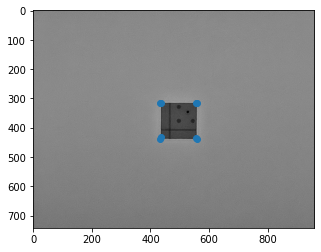

Screenshot 2022-05-26 15_42_33_787889.png
(742, 960, 3)
(4, 8)
[-0.0285219   0.08361898  0.75668156]
[-0.431912    0.7548061  -0.49367982  0.63868076  0.64244854  0.4234935
  0.63681936 -0.13239187 -0.75956136]
[[-0.431912    0.7548061  -0.49367982]
 [ 0.63868076  0.64244854  0.4234935 ]
 [ 0.63681936 -0.13239187 -0.75956136]]
[ 2.99343162e+03  0.00000000e+00  4.80000000e+02  0.00000000e+00
 -2.93065255e+03  3.71000000e+02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
[[ 2.99343162e+03  0.00000000e+00  4.80000000e+02]
 [ 0.00000000e+00 -2.93065255e+03  3.71000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[377.8186   314.5667   466.87967  406.0512   330.571    267.49326
  417.1965   356.4079  ]
 [147.3032    89.92288   71.467804  11.421787  80.75878   22.82336
    6.450509 -54.03966 ]]


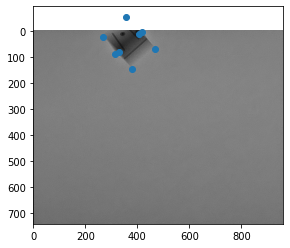

Screenshot 2022-05-26 15_42_49_708961.png
(742, 960, 3)
(4, 8)
[-0.00130151  0.01145481  0.74469024]
[-0.46302414  0.81832486 -0.34051886  0.67733353  0.57447851  0.45955819
  0.57168865 -0.0178583  -0.82027626]
[[-0.46302414  0.81832486 -0.34051886]
 [ 0.67733353  0.57447851  0.45955819]
 [ 0.57168865 -0.0178583  -0.82027626]]
[ 2.99343162e+03  0.00000000e+00  4.80000000e+02  0.00000000e+00
 -2.93065255e+03  3.71000000e+02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
[[ 2.99343162e+03  0.00000000e+00  4.80000000e+02]
 [ 0.00000000e+00 -2.93065255e+03  3.71000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[473.90973 431.4703  572.1315  533.0013  419.7514  376.49594 515.7341
  475.63617]
 [426.64597 372.73633 359.1755  302.93124 347.64066 292.35547 281.62692
  224.10857]]


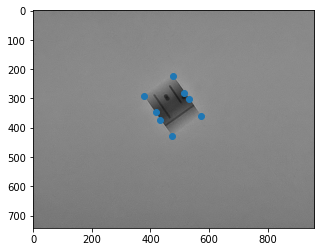

Screenshot 2022-05-26 15_43_02_819496.png
(742, 960, 3)
(4, 8)
[-0.02151414  0.05597738  0.77512282]
[-0.4857178   0.85679638 -0.173142    0.71887976  0.50422907  0.47850284
  0.49728274  0.10794908 -0.86084658]
[[-0.4857178   0.85679638 -0.173142  ]
 [ 0.71887976  0.50422907  0.47850284]
 [ 0.49728274  0.10794908 -0.86084658]]
[ 2.95073688e+03  0.00000000e+00  4.80000000e+02  0.00000000e+00
 -2.88885322e+03  3.71000000e+02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
[[ 2.95073688e+03  0.00000000e+00  4.80000000e+02]
 [ 0.00000000e+00 -2.88885322e+03  3.71000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[387.2562   363.72507  484.60495  464.49844  334.83844  310.00183
  430.57822  409.0516  ]
 [258.06073  199.1249   202.66081  142.08575  181.70459  121.346085
  127.65174   65.736786]]


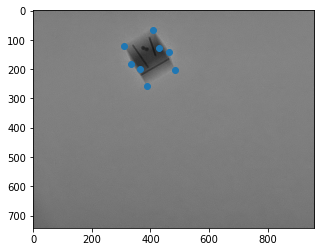

Screenshot 2022-05-26 15_43_19_784459.png
(742, 960, 3)
(4, 8)
[0.00570236 0.01285024 0.70969135]
[-0.49011308  0.87165719 -0.00169469  0.76147175  0.42910287  0.48583069
  0.42420503  0.23682152 -0.87405127]
[[-0.49011308  0.87165719 -0.00169469]
 [ 0.76147175  0.42910287  0.48583069]
 [ 0.42420503  0.23682152 -0.87405127]]
[ 2.97296846e+03  0.00000000e+00  4.80000000e+02  0.00000000e+00
 -2.91061855e+03  3.71000000e+02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
[[ 2.97296846e+03  0.00000000e+00  4.80000000e+02]
 [ 0.00000000e+00 -2.91061855e+03  3.71000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[480.01926 479.79987 587.9957  591.8597  419.77643 417.30243 526.4617
  527.97217]
 [421.20224 361.33948 368.66644 307.43112 328.68802 266.446   277.96176
  214.46295]]


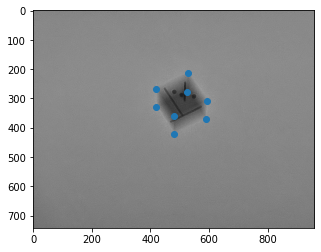

In [7]:
with open(gt_yaml, 'r') as stream:
    try:
        gt = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
    
idx = 0
for item in os.listdir(images_dir):
    print(item)
    if item.endswith(".png"):

        img = cv2.imread(os.path.join(images_dir, item))
        print(img.shape)

        
        
        print(corners3D.shape)
        print(np.array(gt[item[:-4]]['cam_t_m2c']))
        print(np.array(gt[item[:-4]]['cam_R_m2c']))
        print(np.array(gt[item[:-4]]['cam_R_m2c']).reshape(3,3))
        print(np.array(gt[item[:-4]]['cam_K']))
        print(np.array(gt[item[:-4]]['cam_K']).reshape(3,3))

        transformation = np.eye(4)
        transformation[:3,3] = np.array(gt[item[:-4]]['cam_t_m2c'])
        transformation[:3,:3] = np.array(gt[item[:-4]]['cam_R_m2c']).reshape(3,3)
        internal_calibration = np.array(gt[item[:-4]]['cam_K']).reshape(3,3)

        corners2D = compute_projection(corners3D, transformation[:3], internal_calibration)
        print(corners2D)

        # view projected points in matplotlib
        plt.imshow(img)
        plt.scatter(corners2D[0,:], corners2D[1,:])
        plt.show()

        idx += 1
        if idx == 5:

            break

In [8]:
with open(gt_yaml, 'r') as stream:


SyntaxError: unexpected EOF while parsing (1077094751.py, line 1)